!apt install swig
!pip install box2d box2d-kengz

In [18]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import os
%matplotlib inline

#plt.style.use('seaborn')
plt.style.use('fivethirtyeight')

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/SaveFiles/Save/solved_200.pth'
#path = '/content/drive/My Drive/SaveFiles/Save/'
#os.chdir(path)
#!pwd

In [ ]:
env = gym.make('LunarLander-v2')
#env.seed(0)

In [7]:
# inspect action space and state space
print(env.action_space)
print(env.observation_space)

#do nothing, 
#fire left orientation engine,
#fire main engine, 
#fire right orientation engine

Discrete(4)
Box(8,)


In [8]:
state = env.reset() # I have to call this sentecen before env.step(action)
actions = range(env.action_space.n)
action = np.random.choice(actions)
print('action:', action)
state, reward, done, info = env.step(action)
print('state:', state, '\nreward:', reward, '\ndone:', done, '\ninfo:',info)

action: 1
state: [-1.2460708e-03  1.4154155e+00 -6.7727223e-02  8.7033525e-02
  2.9421085e-03  4.5001026e-02  0.0000000e+00  0.0000000e+00] 
reward: 1.291988827466356 
done: False 
info: {}


In [9]:
# Agent that takes random actions
max_episodes = 100

In [10]:
scores = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        state, reward, done, info = env.step(action)
        score += reward
        if done: #if done it's true
            #print('Done:', done)
            if i % 20 == 0:
                print('Episode {},  score: {}'.format(i, score))
            break
    
    scores.append(score)

Episode 20,  score: -144.10346863922962
Episode 40,  score: -109.97465786986396
Episode 60,  score: -65.78840377096623
Episode 80,  score: -112.06817261559333
Episode 100,  score: -77.91141948671776


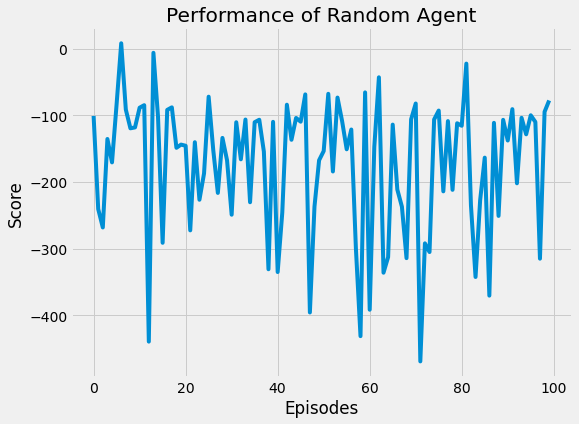

In [11]:
# Show random agent's performance
plt.figure(figsize=(8,6))
plt.plot(range(max_episodes), scores)
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

In [12]:
print('Average score of random agent over {} episodes: {:.2f}'.format(max_episodes, np.mean(scores)))

Average score of random agent over 100 episodes: -172.65


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [14]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Build a fully connected neural network
        
        Parameters
        ----------
        state_size (int): State dimension
        action_size (int): Action dimension
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)  
        
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x        

In [15]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory allow agent to record experiences and learn from them
        
        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        seed (int): random seed
        """
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        """ 
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors 
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [16]:
BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """
        DQN Agent interacts with the environment, 
        stores the experience and learns from it
        
        Parameters
        ----------
        state_size (int): Dimension of state
        action_size (int): Dimension of action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Initialize Q and Fixed Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # Initiliase memory 
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        
    
    def step(self, state, action, reward, next_state, done):
        """
        Update Agent's knowledge
        
        Parameters
        ----------
        state (array_like): Current state of environment
        action (int): Action taken in current state
        reward (float): Reward received after taking action 
        next_state (array_like): Next state returned by the environment after taking action
        done (bool): whether the episode ended after taking action
        """
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
        
    def learn(self, experiences):
        """
        Learn from experience by training the q_network 
        
        Parameters
        ----------
        experiences (array_like): List of experiences sampled from agent's memory
        """
        states, actions, rewards, next_states, dones = experiences
        # Get the action with max Q value
        action_values = self.fixed_network(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights
        self.update_fixed_network(self.q_network, self.fixed_network)
        
    def update_fixed_network(self, q_network, fixed_network):
        """
        Update fixed network by copying weights from Q network using TAU param
        
        Parameters
        ----------
        q_network (PyTorch model): Q network
        fixed_network (PyTorch model): Fixed target network
        """
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        
    def act(self, state, eps=0.0):
        """
        Choose the action
        
        Parameters
        ----------
        state (array_like): current state of environment
        eps (float): epsilon for epsilon-greedy action selection
        """
        rnd = random.random()
        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            # set the network into evaluation mode 
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            # Back to training mode
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

In [17]:
# Copying the hyperparameters again here, for reference 

BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

MAX_EPISODES = 2000  # Max number of episodes to play
MAX_STEPS = 1000     # Max steps allowed in a single episode/play
ENV_SOLVED = 200     # MAX score at which we consider environment to be solved
PRINT_EVERY = 100    # How often to print the progress

# Epsilon schedule

EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01 

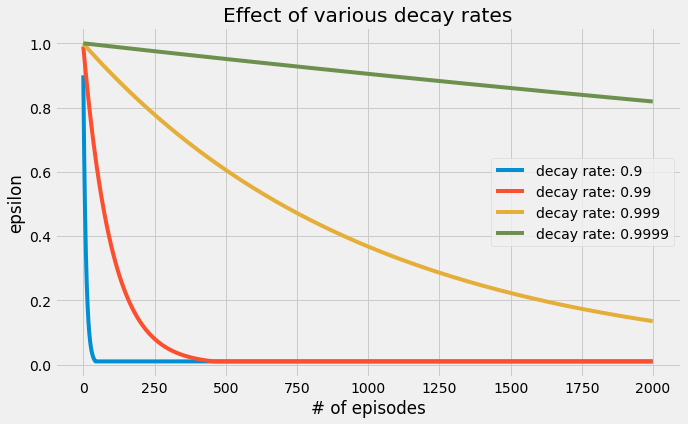

In [18]:
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]
plt.figure(figsize=(10,6))

for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          
    
    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate))

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

In [19]:
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [20]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)

In [21]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            #dqn_agent.checkpoint('solved_200.pth')
            dqn_agent.checkpoint(path)
            break
            
    scores_window.append(score)
    scores.append(score)
    
end = time()    
print('Took {} seconds'.format(end - start))

 Progress 2000/2000, average score:251.41Took 2309.545783519745 seconds


In [22]:
#dqn_agent.checkpoint('solved_200.pth')
dqn_agent.checkpoint(path)

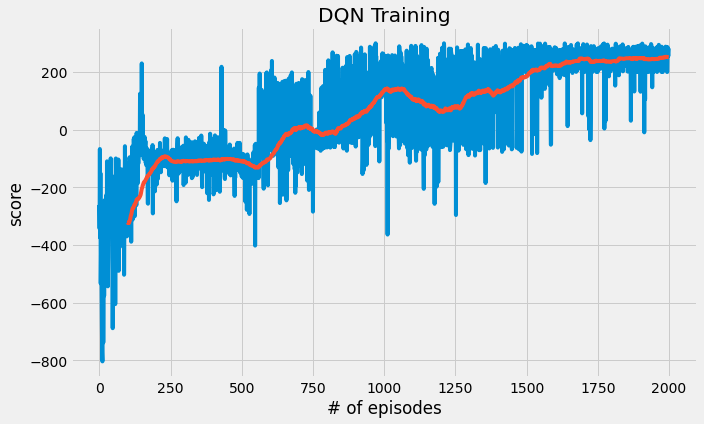

In [23]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [26]:
dqn_agent.q_network.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
## Uncomment if you wish to save the video
path1 = '/content/drive/My Drive/SaveFiles/Save/lunar-lander-6'

from gym import wrappers
if env:
    env.close()
env = gym.make('LunarLander-v2')
env.seed(0)
env = wrappers.Monitor(env, path1, video_callable=lambda episode_id: True)

In [ ]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print('episode: {} scored {}'.format(i, score))

In [ ]:
env.close()